# Image Classification Model Using LeNet

In [10]:
import os
from torchvision import datasets, transforms 
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm

In [2]:
class HarDataset(Dataset):
    def __init__(self, root_dir, data, transform=None):
        self.root_dir = root_dir
        self.data_df = data
        self.transform = transform
        self.label_map = self._create_label_map()

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_df.iloc[idx, 0])
        image = Image.open(img_name)
        label = self.data_df.iloc[idx, 1]
        label = self.label_map[label]

        if self.transform:
            image = self.transform(image)

        return image, label

    def _create_label_map(self):
        unique_labels = sorted(self.data_df['label'].unique())
        label_map = {label: idx for idx, label in enumerate(unique_labels)}
        return label_map

In [7]:
# Define transforms for data augmentation

# Use this for colored images
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
    ])

# Use this for BnW images
# transform = transforms.Compose([
#     transforms.Resize((32, 32)),
#     transforms.Grayscale(num_output_channels=1),  # Convert to black and white
#     transforms.ToTensor(),
# ])

In [4]:

# Define the paths 

path = r'/Users/azeez/Desktop/AI/Personal Projects/GitHub/Computer-Vision-using-PyTorch/Human Action Recognition' 
folder = 'train' 
activity = 'cycling' 
img_name = 'Image_93.jpg' 

# construct the full image path 
img_path = os.path.join(path, folder, activity, img_name)

# Open and display the image 
image = Image.open(img_path)
image.show() 


In [5]:
print(image.size)

(385, 131)


In [6]:

print(image.mode)

RGB


In [8]:
train_root_dir = r'/Users/azeez/Desktop/AI/Personal Projects/GitHub/Computer-Vision-using-PyTorch/Human Action Recognition/train'
# train_file = r'C:\Users\Deepak\Downloads\Computer Vision Resources\Human Action Recognition\Modified_Training_set.csv'
test_root_dir = r'/Users/azeez/Desktop/AI/Personal Projects/GitHub/Computer-Vision-using-PyTorch/Human Action Recognition/test'
# test_file = r'C:\Users\Deepak\Downloads\Computer Vision Resources\Human Action Recognition\Reduced_Testing_set.csv'

In [11]:
# Apply the transforms to the train and test data 
train_data = datasets.ImageFolder(root=train_root_dir, transform=transform )
test_data = datasets.ImageFolder(root=test_root_dir, transform=transform)

In [12]:
print(train_data.classes)
num_classes = len(train_data.classes)
print(num_classes)

['cycling', 'dancing', 'drinking', 'eating', 'sitting']
5


In [13]:
from collections import Counter 

Counter({'dancing': 714, 'drinking': 714, 'sitting': 714, 'eating': 714, 'cycling': 714})


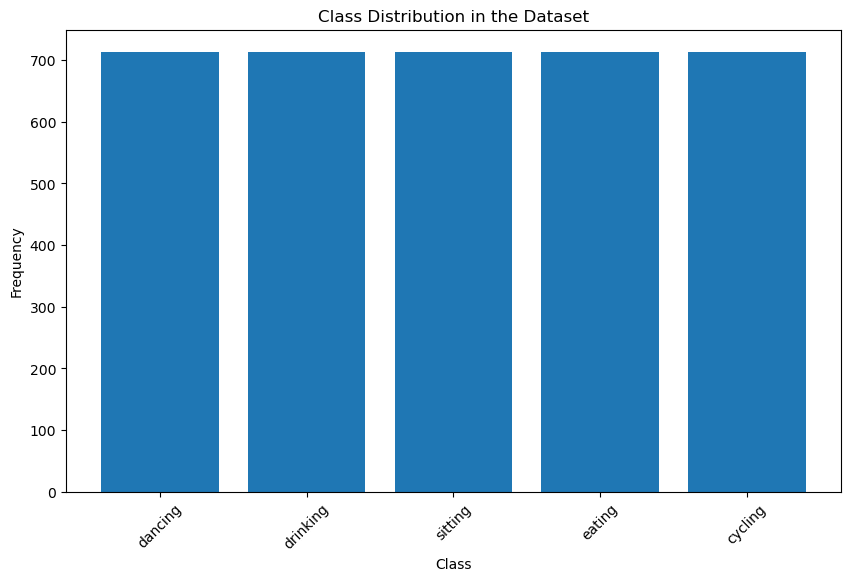

In [16]:
# checking class distribution 

class_distribution = Counter([label for label in os.listdir(train_root_dir) if os.path.isdir(os.path.join(train_root_dir, label))])

# Get the count of images in each class 
for label in class_distribution:
    class_distribution[label] = len(os.listdir(os.path.join(train_root_dir, label)))
    
# Print the class distribution 
print(class_distribution)

# Plotting the class distribution 
plt.figure(figsize=(10,6))
plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution in the Dataset')
plt.xticks(rotation=45) # Rotate class labels for better readability 
plt.show()

### LeNet Architecture 

In [18]:
# Define LeNet-5 model
class LeNet5(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, padding=0, stride=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, padding=0, stride=1)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.flatten(x, 1)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [19]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
device

device(type='cpu')

In [21]:
# Initialize LeNet-5 model
model = LeNet5().to(device)

In [22]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
# Define data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(test_data, batch_size=32, shuffle=False)